# Cascade of two-neuron modules
*Nhat Le, November 2017*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [2]:
def ecdf(x):
    return np.sort(x), np.arange(len(x)) / len(x)

def save_safe(filename):
    '''Raise an error if file exists'''
    if not os.path.isfile(filename):
        plt.savefig(filename)
    else:
        raise IOError('File exists!')

def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

## A Class for a two-neuron module

In [13]:
## Define an object class for simulation
class TwoNeuronModule:
    def __init__(self, Wut, Wvt, Wuv, Wvu, theta, tau, dt, 
                 sigma_mu, sigma_sigma, threshold, K=0):
        self.Wut = Wut
        self.Wvt = Wvt
        self.Wuv = Wuv
        self.Wvu = Wvu
        self.theta = theta
        self.tau = tau
        self.dt = dt
        self.sigma_mu = sigma_mu
        self.sigma_sigma = sigma_sigma
        self.ext = 0
        self.threshold = threshold
        self.K = K
 
    def _initialize_state(self, u_init, v_init, ntrials):
        '''Initialize n states, each set to (u_init, v_init)'''
        self.ustate = np.array([u_init] * ntrials)
        self.vstate = np.array([v_init] * ntrials)
        self.ext = np.random.normal(0, self.sigma_mu, ntrials)

    def _find_u_dot_multi(self):
        noise = np.random.normal(loc=0, scale=self.sigma_sigma, size=len(self.ustate))
        return (-self.ustate + thresh_exp(self.Wut * self.theta - \
                                          self.Wuv * self.vstate + noise + self.ext)) / self.tau
    
    def _find_v_dot_multi(self):
        noise = np.random.normal(loc=0, scale=self.sigma_sigma, size=len(self.ustate))
        return (-self.vstate + thresh_exp(self.Wut * self.theta - \
                                          self.Wuv * self.ustate + noise + self.ext)) / self.tau

    def _update_state(self):
        '''An update for a single time step dt'''
        order = np.random.randint(0, 2) # Choose to update u or v first
        if order:
            self.ustate = self.ustate + self._find_u_dot_multi() * self.dt
            self.vstate = self.vstate + self._find_v_dot_multi() * self.dt
        else:
            self.vstate = self.vstate + self._find_v_dot_multi() * self.dt
            self.ustate = self.ustate + self._find_u_dot_multi() * self.dt
    
    def simulate_full_trial(self, u_init, v_init, ntrials, nsteps):
        self._initialize_state(u_init, v_init, ntrials)
        self.u_lst = []
        self.v_lst = []
        for i in range(nsteps):
            self.u_lst.append(self.ustate.copy())
            self.v_lst.append(self.vstate.copy())
            self._update_state()
        
        self.u_lst = np.vstack(self.u_lst)
        self.v_lst = np.vstack(self.v_lst)
        return self.u_lst, self.v_lst
    
    def get_decision_v(self):
        return self.u_lst - self.v_lst
    
    def get_feedback(self, time_feedback):
        return self.K * (self.get_decision_v()[time_feedback] - self.threshold) 
    
    def find_tp(self):
        decision_v = self.get_decision_v()
        times_lst = []
        for k in range(self.u_lst.shape[1]):
            if np.max(decision_v[:, k]) > self.threshold:
                times_lst.append(np.nonzero(decision_v[:, k] > self.threshold)[0][0])
            else:
                times_lst.append(np.inf)
                
        return np.array(times_lst)

In [5]:
module = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=0.613, tau=100, dt=1, 
                         sigma_mu=0.1, sigma_sigma=0.5, threshold=0.65, K=0)
module._initialize_state(0.7, 0.2, 1)
a, b = module.simulate_full_trial(0.7, 0.2, 100, 1000)
times = module.find_tp()

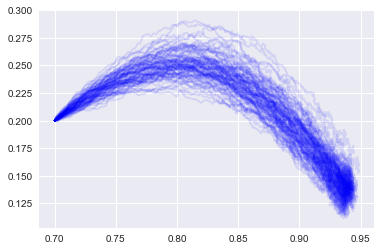

In [6]:
plt.plot(a,b,'b', alpha=0.1);

199.97


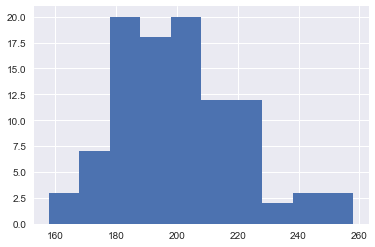

In [7]:
print(np.mean(times))
plt.hist(times);

In [ ]:
def simulate_module(ntrials, nsteps, nsteps_goal, ext_lst, params, 
                    K, prev_final=np.array([]), ext_updating=False):
    '''Simulate a single module
    Returns the list of final positions'''
    ext_lst_new = np.array(ext_lst)
    state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
    if ext_updating:
        assert(prev_final.shape != (0,))
        ext_lst_new += K * (prev_final - np.mean(prev_final))
    params['ext'] = ext_lst_new
    
    ulst_noise, vlst_noise = simulate_u_v_exp_multi(state_dict, params, nsteps)
    decision_v = ulst_noise - vlst_noise
    
    threshold = np.nanmean(decision_v[nsteps_goal]) # TODO: check if this is a valid threshold
    times_lst = get_times_lst_from_decision_v(decision_v, threshold)
    
    return ext_lst_new, (ulst_noise - vlst_noise)[nsteps_goal, :], np.array(times_lst)

## The no-noise condition

In [14]:
thetas_lst = np.linspace(0.5, 0.7, 20)
module_no_noise = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=thetas_lst, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0, threshold=0.65, K=0)
ulst_no_noise, vlst_no_noise = module_no_noise.simulate_full_trial(0.7, 0.2, 20, 3000)
times_no_noise = module_no_noise.find_tp()

A plot of the trajectories for 20 values of $\theta$ from 0.5 to 0.7 (no noise)

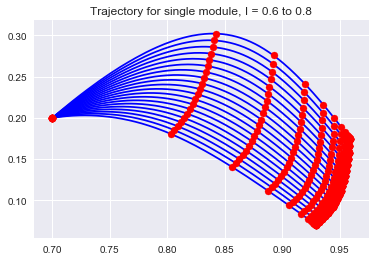

In [15]:
plt.plot(ulst_no_noise, vlst_no_noise, 'b');
plt.scatter(ulst_no_noise[::100,:], vlst_no_noise[::100,:], color='r', zorder=4)
plt.title('Trajectory for single module, I = 0.6 to 0.8')

As expected, having two modules simply doubles the production time of a single module

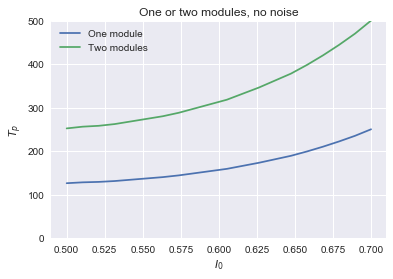

In [16]:
module1 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=np.linspace(0.5, 0.7, 20), tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0, threshold=0.65, K=0)
_ = module1.simulate_full_trial(0.7, 0.2, 20, 3000)
module2 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=np.linspace(0.5, 0.7, 20), tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0, threshold=0.65, K=0)
_ = module2.simulate_full_trial(0.7, 0.2, 20, 3000)

times1 = module1.find_tp()
times2 = module2.find_tp()

plt.plot(thetas_lst, times1, label='One module')
plt.plot(thetas_lst, times1 + times2, label='Two modules')
plt.ylim(0, 500)
plt.xlabel(r'$I_0$')
plt.ylabel(r'$T_p$')
plt.legend()
plt.title('One or two modules, no noise')

## Effect of $\sigma_\sigma$

We first simulate a single module. We adjust $\theta$ to make the mean time to threshold = 400

In [17]:
# One module case to produce Tp = 400
module = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=0.752, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0.3, threshold=0.65)
ulst, vlst = module.simulate_full_trial(0.7, 0.2, 1000, 1000)
times_single = module.find_tp()

print('One module, mean = %f, variance = %f' % (np.mean(times_single), np.var(times_single)))

One module, mean = 398.361000, variance = 433.530679


For two modules, we can again adjust $\theta$ to make sure the mean total time is 400

In [19]:
# Two modules
module1 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=0.644, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0.3, threshold=0.65)
_ = module1.simulate_full_trial(0.7, 0.2, 1000, 3000)
module2 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=0.644, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0.3, threshold=0.65)
_ = module2.simulate_full_trial(0.7, 0.2, 1000, 3000)

times_two_modules = module1.find_tp() + module2.find_tp()

print('Two modules, mean = %f, variance = %f' % (np.mean(times_two_modules), np.var(times_two_modules)))

Two modules, mean = 399.183000, variance = 156.689511


And we compare the distribution of times! The two modules has a lower variance (3.9 compared to 20.4). But why? I don't have a good intuition here.

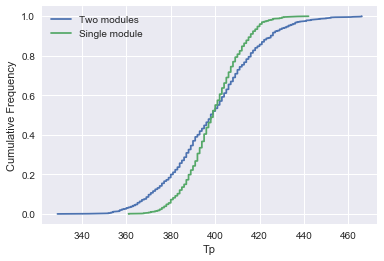

In [21]:
x1, y1 = ecdf(times_single)
x2, y2 = ecdf(times_two_modules)
plt.plot(x1, y1, label='Two modules')
plt.plot(x2, y2, label='Single module')
plt.xlabel('Tp')
plt.ylabel('Cumulative Frequency')
plt.legend()


## Update model

Now here's the part where we make use of the update. We assume the threshold information is known (kept at 0.65), and subtract the final state of the system from the threshold.

In [22]:
# Two modules
varlst = []
meanlst = []
Klst = np.linspace(0, 3, 20)
thetalst = np.linspace(0.5, 0.7, 10)
meanlst = np.zeros((10, 20))
varlst = np.zeros((10, 20))

for idtheta, theta in enumerate(thetalst):
    print('theta = ', theta)
    for idK, K in enumerate(Klst):
        # Module 1
        print('    K = ', K)
        module1 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=theta, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0.3, threshold=0.65, K=K)
        ulst_noise_sigma1, vlst_noise_sigma1 = module1.simulate_full_trial(0.7, 0.2, 1000, 3000)
        decision_sigma1 = module1.get_decision_v()

        # Module 2 with correction
        theta2 = theta + module1.get_feedback(199) #K * (decision_sigma1[199] - threshold)
        module2 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=theta2, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=0.3, threshold=0.65, K=K)
        ulst_noise_sigma2, vlst_noise_sigma2 = module2.simulate_full_trial(0.7, 0.2, 1000, 3000)
        times_lst_sigma = module1.find_tp() + module2.find_tp()

        #meanlst.append(np.mean(times_lst_sigma))
        #varlst.append(np.std(times_lst_sigma))
        meanlst[idtheta, idK] = np.mean(times_lst_sigma)
        varlst[idtheta, idK] = np.std(times_lst_sigma)

theta =  0.5
    K =  0.0
    K =  0.157894736842
    K =  0.315789473684
    K =  0.473684210526
    K =  0.631578947368
    K =  0.789473684211
    K =  0.947368421053
    K =  1.10526315789
    K =  1.26315789474
    K =  1.42105263158
    K =  1.57894736842
    K =  1.73684210526
    K =  1.89473684211
    K =  2.05263157895
    K =  2.21052631579
    K =  2.36842105263
    K =  2.52631578947
    K =  2.68421052632
    K =  2.84210526316
    K =  3.0
theta =  0.522222222222
    K =  0.0
    K =  0.157894736842
    K =  0.315789473684
    K =  0.473684210526
    K =  0.631578947368
    K =  0.789473684211
    K =  0.947368421053
    K =  1.10526315789
    K =  1.26315789474
    K =  1.42105263158
    K =  1.57894736842
    K =  1.73684210526
    K =  1.89473684211
    K =  2.05263157895
    K =  2.21052631579
    K =  2.36842105263
    K =  2.52631578947
    K =  2.68421052632
    K =  2.84210526316
    K =  3.0
theta =  0.544444444444
    K =  0.0
    K =  0.157894736842
    K =  0

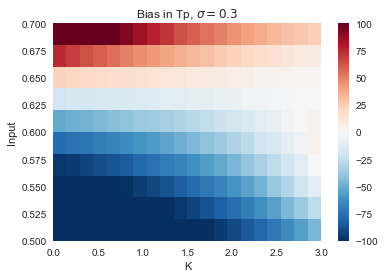

In [23]:
plt.imshow(np.flipud(meanlst - 400), cmap='RdBu_r', aspect='auto', \
           extent=[0, 3, 0.5, 0.7], vmin=-100, vmax=100)
plt.grid(False)
plt.colorbar()
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Bias in Tp, $\sigma=0.3$')
#save_safe('bias_two_modules_sigma_0_3.pdf')

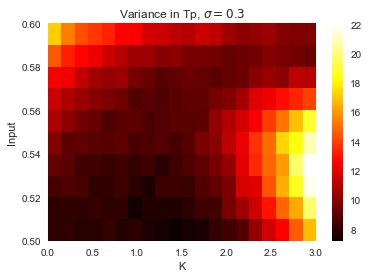

In [24]:
plt.imshow(np.flipud(varlst), cmap='hot', aspect='auto', extent=[0, 3, 0.5, 0.6])
plt.colorbar()
plt.grid(False)
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Variance in Tp, $\sigma=0.3$')
#save_safe('variance_two_modules_sigma_0_3.pdf')

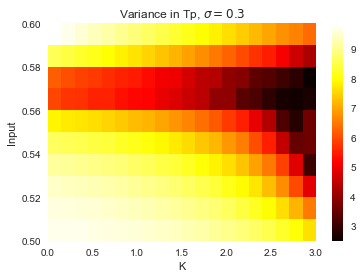

In [25]:
plt.imshow((np.log(np.flipud((meanlst - 400)**2 +  varlst))), cmap='hot', aspect='auto', extent=[0, 3, 0.5, 0.6])
plt.colorbar()
plt.grid(False)
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Variance in Tp, $\sigma=0.3$')
#save_safe('bias_variance_two_modules_sigma_0_3.pdf')

An optimal value of $K = 1.5$ is found to minimize the variance in $T_p$. There seems to be a bias in the mean $T_p$ as well. The point of minimum variance also happens to have zero bias. Is this a coincidence?

## Effect of $\sigma_\sigma$

In the previous section we worked with a single value $\sigma_\sigma=0.3$. Here we would like to get a sense of how the optimal value of $K$ changes as a function of $\sigma_\sigma$.

This is the theta that will give an expected time of 400 for values of $\sigma_\sigma$ = 0, 0.1, 0.2, ..., 0.5

In [26]:
theta_lst = np.array([[0    , 0.1  , 0.2  , 0.3  , 0.4  , 0.5  ],
                      [0.659, 0.658, 0.653, 0.644, 0.632, 0.613]])

In [28]:
Klst = np.linspace(0, 3, 10)
varlst = np.zeros((6, 10))
meanlst = np.zeros((6, 10))

for i in range(theta_lst.shape[1]):
    sigma_sigma = theta_lst[0, i]
    theta = theta_lst[1, i]
    for j, K in enumerate(Klst):
        print('Working, i = ', i, 'K = ', K)
        # Module 1
        module1 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=theta, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=sigma_sigma, threshold=0.65, K=K)
        ulst_noise_sigma1, vlst_noise_sigma1 = module1.simulate_full_trial(0.7, 0.2, 1000, 3000)
        decision_sigma1 = module1.get_decision_v()

        # Module 2 with correction
        theta2 = theta + module1.get_feedback(199)
        module2 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=theta2, tau=100, dt=1, 
                         sigma_mu=0, sigma_sigma=sigma_sigma, threshold=0.65, K=K)
        ulst_noise_sigma2, vlst_noise_sigma2 = module2.simulate_full_trial(0.7, 0.2, 1000, 3000)
        times_lst_sigma = module1.find_tp() + module2.find_tp()
        
        varlst[i][j] = np.std(times_lst_sigma)
        meanlst[i][j] = np.mean(times_lst_sigma)

Working, i =  0 K =  0.0
Working, i =  0 K =  0.333333333333
Working, i =  0 K =  0.666666666667
Working, i =  0 K =  1.0
Working, i =  0 K =  1.33333333333
Working, i =  0 K =  1.66666666667
Working, i =  0 K =  2.0
Working, i =  0 K =  2.33333333333
Working, i =  0 K =  2.66666666667
Working, i =  0 K =  3.0
Working, i =  1 K =  0.0
Working, i =  1 K =  0.333333333333
Working, i =  1 K =  0.666666666667
Working, i =  1 K =  1.0
Working, i =  1 K =  1.33333333333
Working, i =  1 K =  1.66666666667
Working, i =  1 K =  2.0
Working, i =  1 K =  2.33333333333
Working, i =  1 K =  2.66666666667
Working, i =  1 K =  3.0
Working, i =  2 K =  0.0
Working, i =  2 K =  0.333333333333
Working, i =  2 K =  0.666666666667
Working, i =  2 K =  1.0
Working, i =  2 K =  1.33333333333
Working, i =  2 K =  1.66666666667
Working, i =  2 K =  2.0
Working, i =  2 K =  2.33333333333
Working, i =  2 K =  2.66666666667
Working, i =  2 K =  3.0
Working, i =  3 K =  0.0
Working, i =  3 K =  0.333333333333
Wor

Interestingly, the bias is relatively constant while the minimum point of the variance occurs consistently at $K \approx 1.5$

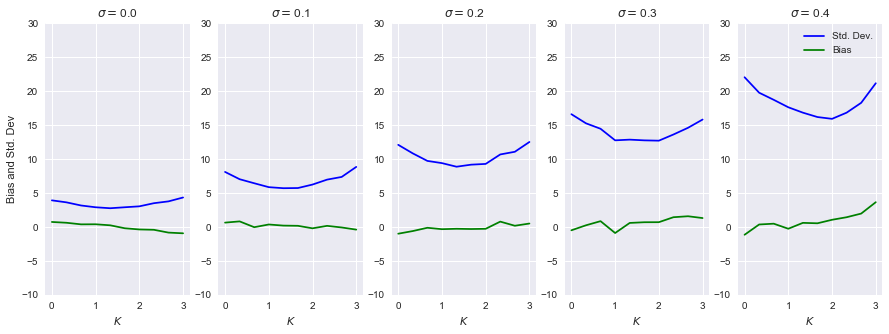

In [30]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(1, 6):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    ax[i-1].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    ax[i-1].plot(Klst, meanlst[i] - 400, color='g', label='Bias')
    ax[i-1].set_ylim((-10, 30))
    ax[i-1].set_xlabel(r'$K$')
    ax[i-1].set_title(r'$\sigma=$' + str(theta_lst[0, i-1]))
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')

ax[0].set_ylabel('Bias and Std. Dev')
ax[4].legend();
#save_safe('bias_variance_sigma_sigma.pdf')


## Effect of $\sigma_\mu$

We now turn to the effect of $\sigma_\mu$ and try to find values of $K$ that help the system correct its $T_p$. My previous result has shown that the bias of $T_p$ can be kept close to 0 at certain values of $\theta$, while the variance can be controlled by $K$. Thus, we can reuse the $\theta$ table obtained previously to set the right $I$ for the system to achieve time = 400.

In [38]:
# Two modules
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
mu_ext = np.random.normal(0, 0.3, ntrials)
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': theta, 'tau': 100, 'dt': 1, 'ext': mu_ext, 'sigma': 0}

module1 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=0.644, tau=100, dt=1, 
                         sigma_mu=0.3, sigma_sigma=0, threshold=0.65)
module1.simulate_full_trial(0.7, 0.2, 1000, 3000)

module2 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=theta, tau=100, dt=1, 
                         sigma_mu=0.3, sigma_sigma=0, threshold=0.65)
module2.simulate_full_trial(0.7, 0.2, 1000, 3000)
times_lst_sigma = module1.find_tp() + module2.find_tp()

print(np.mean(times_lst_sigma))

inf


Again we see the familiar shape of the $\sigma_\mu$ trials with a more 'ordered' time steps. At large values of $\sigma_\mu$, deviations can be detrimental as the system never crosses threshold.

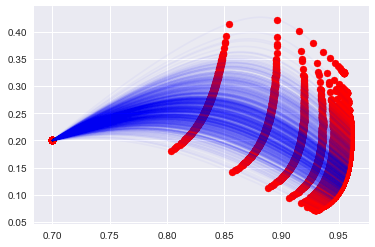

In [48]:
plt.plot(module1.u_lst, module1.v_lst, 'b', alpha=0.03);
plt.scatter(module1.u_lst[::100,:], module1.v_lst[::100,:], color='r');

Now we try to introduce updating with $K$ and see what happens

In [67]:
# Two modules
varlst = []
meanlst = []
Klst = np.linspace(0, 4, 20)
meanlst = np.zeros((10, 20))
varlst = np.zeros((10, 20))

for idtheta, theta in enumerate(np.linspace(0.5, 0.7, 10)):
    print('theta = ', theta)
    for idK, K in enumerate(Klst):
        param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
                  'theta': theta, 'tau': 100, 'dt': 1, 'ext': mu_ext, 'sigma': 0}
        # Module 1
        print('    K = ', K)
        module1 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=theta, tau=100, dt=1, 
                         sigma_mu=0.1, sigma_sigma=0, threshold=0.65, K=K)
        module1.simulate_full_trial(0.7, 0.2, 1000, 3000)

        # Module 2 with correction
        theta2 = theta + module1.get_feedback(199)
        module2 = TwoNeuronModule(Wut=6, Wuv=6, Wvt=6, Wvu=6, theta=theta2, tau=100, dt=1, 
                         sigma_mu=0.1, sigma_sigma=0, threshold=0.65, K=K)
        module2.simulate_full_trial(0.7, 0.2, 1000, 3000)

        times_lst_sigma = module1.find_tp() + module2.find_tp()
        
        meanlst[idtheta, idK] = np.mean(times_lst_sigma[times_lst_sigma < np.inf])
        varlst[idtheta, idK] = np.std(times_lst_sigma[times_lst_sigma < np.inf])

theta =  0.5
    K =  0.0
    K =  0.210526315789
    K =  0.421052631579
    K =  0.631578947368
    K =  0.842105263158
    K =  1.05263157895
    K =  1.26315789474
    K =  1.47368421053
    K =  1.68421052632
    K =  1.89473684211
    K =  2.10526315789
    K =  2.31578947368
    K =  2.52631578947
    K =  2.73684210526
    K =  2.94736842105
    K =  3.15789473684
    K =  3.36842105263
    K =  3.57894736842
    K =  3.78947368421
    K =  4.0
theta =  0.522222222222
    K =  0.0
    K =  0.210526315789
    K =  0.421052631579
    K =  0.631578947368
    K =  0.842105263158
    K =  1.05263157895
    K =  1.26315789474
    K =  1.47368421053
    K =  1.68421052632
    K =  1.89473684211
    K =  2.10526315789
    K =  2.31578947368
    K =  2.52631578947
    K =  2.73684210526
    K =  2.94736842105
    K =  3.15789473684
    K =  3.36842105263
    K =  3.57894736842
    K =  3.78947368421
    K =  4.0
theta =  0.544444444444
    K =  0.0
    K =  0.210526315789
    K =  0.421

In [65]:
np.nanmean(times_lst_sigma)

inf

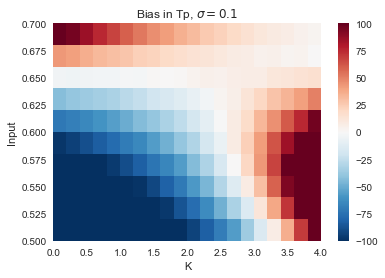

In [68]:
plt.imshow(np.flipud(meanlst - 400), cmap='RdBu_r', aspect='auto', \
           vmin = -100, vmax=100, extent=[0, 4, 0.5, 0.7])
plt.grid(False)
plt.colorbar()
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Bias in Tp, $\sigma=0.1$')
#save_safe('bias_two_modules_sigma_mu_0_1.pdf')

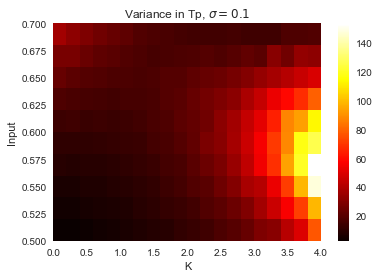

In [69]:
plt.imshow(np.flipud(varlst), cmap='hot', aspect='auto', \
           extent=[0, 4, 0.5, 0.7])
plt.grid(False)
plt.colorbar()
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Variance in Tp, $\sigma=0.1$')
#save_safe('variance_two_modules_sigma_mu_0_1.pdf')

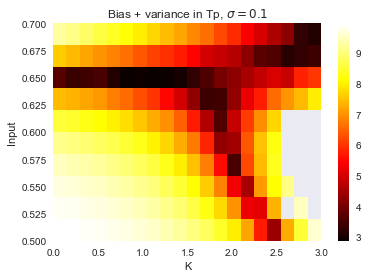

In [59]:
plt.imshow(np.log(np.flipud(varlst + (meanlst - 400)**2)), cmap='hot', aspect='auto', \
           extent=[0, 3, 0.5, 0.7])
plt.grid(False)
plt.colorbar()
plt.xlabel('K')
plt.ylabel('Input')
plt.title(r'Bias + variance in Tp, $\sigma=0.1$')
#save_safe('bias_variance_two_modules_sigma_mu_0_1.pdf')

In [ ]:
# Two modules
ntrials = 1000
nsteps = 3000
theta = 0.656 # This makes mean = 400

mu_ext = np.random.normal(0, 0.1, ntrials)
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': theta, 'tau': 100, 'dt': 1, 'ext': mu_ext, 'sigma': 0}
varlst = []
meanlst = []
Klst = np.linspace(0, 4, 15)

for K in Klst:
    # Module 1
    print(K)
    param_dict_module['theta'] = theta # Initial theta
    state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
    ulst_noise_sigma1, vlst_noise_sigma1 = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)
    
    decision_sigma1 = ulst_noise_sigma1 - vlst_noise_sigma1

    # Module 2 with correction
    theta2 = theta + K * (decision_sigma1[199] - threshold)
    
    param_dict_module['theta'] = theta2
    ulst_noise_sigma2, vlst_noise_sigma2 = simulate_u_v_exp_multi(state_dict, param_dict_module, nsteps)
    
    decision_sigma2 = ulst_noise_sigma2 - vlst_noise_sigma2
    times_lst_sigma1 = get_times_lst_from_decision_v(decision_sigma1, threshold)
    times_lst_sigma2 = get_times_lst_from_decision_v(decision_sigma2, threshold)
    times_lst_sigma = times_lst_sigma1 + times_lst_sigma2
    varlst.append(np.std(times_lst_sigma))
    meanlst.append(np.mean(times_lst_sigma))

Some preliminary conclusions: (1) The value of $\theta$ computed in the table seems to give the lowest bias in  mean $T_p$ (2) Changing $\theta$ around this value shifts the Mean $T_p$ curve left or right and does not change the minimum point of the variance. Thus we can make the zero bias coincide with the minimum point in variance

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot('121')
plt.plot(Klst, meanlst)
plt.xlabel('K')
plt.ylabel('Mean Tp')

plt.subplot('122')
plt.plot(Klst, varlst, '.')
plt.xlabel('K')
plt.ylabel('Standard Deviation Tp')

In [ ]:
ntrials = 100
nsteps = 5000
goal = 500
Kval = 3
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
threshold = 0.1

# Module 1
ext_module1 = np.random.normal(loc=0, scale=0.3, size=ntrials)
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': 0.2}
_, final_pos1, times_lst1 = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                            param_dict_module, K=Kval, ext_updating=False)
#times_lst1 = get_times_lst(state_dict, param_dict_module, nsteps, threshold)

# Module 2
ext_module2, final_pos2, times_lst2 = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos1, ext_updating=True)

# Module3
ext_module3, final_pos3, times_lst3 = simulate_module(ntrials, nsteps, goal, ext_module2, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos2, ext_updating=True)

In [ ]:
ntrials = 100
nsteps = 5000
goal = 1500
Kval = 3
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
threshold = 0.1

# Module 1
ext_module1 = np.random.normal(loc=0, scale=0.3, size=ntrials)
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': 0.2}
_, final_pos_single, times_lst_single = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                            param_dict_module, K=Kval, ext_updating=False)

In [ ]:
def simulate_multiple_modules(ntrials, nsteps, total_duration, Kval, nmodules, sigma_mu, sigma_sigma):
    '''Simulate multiple modules in a cascade.
    ntrials: number of trials
    nsteps: number of time steps per trial
    total_duration: total time steps for N modules
    Kval: constant K for updating input
    nmodules: number of modules'''
    param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': sigma_sigma}
    subgoal = int(total_duration / nmodules)
    
    # Initial input to module 1
    ext_module_init = np.random.normal(loc=0, scale=sigma_mu, size=ntrials)

    for i in range(nmodules):
        print('Simulating module', i)
        if i == 0:
            ext_module, final_pos, total_times = simulate_module(ntrials, nsteps, subgoal, ext_module_init, 
                                                      param_dict_module, 
                                          K=Kval, ext_updating=False)
        else:
            ext_module, final_pos, times_lst = simulate_module(ntrials, nsteps, subgoal, ext_module, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos, ext_updating=True)
            total_times += times_lst
    return total_times

In [ ]:
palette = sns.hls_palette(8, l=0.5, s=0.8)
#palette = sns.color_palette('hls', 10)
for i in range(1, 9):
    time_lst = simulate_multiple_modules(1000, 5000, 1500, 3, i, 0.5, 0.2)
    x, y = ecdf(time_lst)
    plt.plot(x, y, color=palette[i - 1], label=str(i))
plt.legend(title='N modules', ncol=2)
plt.xlabel('Time (steps)')
plt.ylabel('Cumulative Frequency')
#save_safe('cascade_performance.pdf')

In [ ]:
ntrials = 100
nsteps = 5000
goal = 500
Kval = 3
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
threshold = 0.1

# Module 1
ext_module1 = np.random.normal(loc=0, scale=0.3, size=ntrials)
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': 0.2}
_, final_pos1, times_lst1 = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                            param_dict_module, K=Kval, ext_updating=False)
#times_lst1 = get_times_lst(state_dict, param_dict_module, nsteps, threshold)

# Module 2
ext_module2, final_pos2, times_lst2 = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos1, ext_updating=True)

# Module3
ext_module3, final_pos3, times_lst3 = simulate_module(ntrials, nsteps, goal, ext_module2, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos2, ext_updating=True)

In [ ]:
times_lst1 + times_lst2 + times_lst3

In [ ]:
ntrials = 100
nsteps = 5000
goal = 150
Kval = 3
state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
threshold = 0.1

# Module 1
ext_module1 = np.random.normal(loc=0, scale=0.3, size=ntrials)
param_dict_module = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': 0.2}
_, final_pos1, times_lst1 = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                            param_dict_module, K=Kval, ext_updating=False)
#times_lst1 = get_times_lst(state_dict, param_dict_module, nsteps, threshold)

# Module 2
ext_module2, final_pos2, times_lst2 = simulate_module(ntrials, nsteps, goal, ext_module1, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos1, ext_updating=True)

# Module3
ext_module3, final_pos3, times_lst3 = simulate_module(ntrials, nsteps, goal, ext_module2, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos2, ext_updating=True)
ext_module4, final_pos4, times_lst4 = simulate_module(ntrials, nsteps, goal, ext_module3, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos3, ext_updating=True)
ext_module5, final_pos5, times_lst5 = simulate_module(ntrials, nsteps, goal, ext_module4, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos4, ext_updating=True)
ext_module6, final_pos6, times_lst6 = simulate_module(ntrials, nsteps, goal, ext_module5, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos5, ext_updating=True)
ext_module7, final_pos7, times_lst7 = simulate_module(ntrials, nsteps, goal, ext_module6, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos6, ext_updating=True)
ext_module8, final_pos8, times_lst8 = simulate_module(ntrials, nsteps, goal, ext_module7, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos7, ext_updating=True)
ext_module9, final_pos9, times_lst9 = simulate_module(ntrials, nsteps, goal, ext_module8, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos8, ext_updating=True)
ext_module10, final_pos10, times_lst10 = simulate_module(ntrials, nsteps, goal, ext_module9, 
                                                      param_dict_module, 
                                          K=Kval, prev_final=final_pos9, ext_updating=True)

In [ ]:
plt.hist(times_lst1[times_lst1 < 1000], normed=True, range=(0, 1000))
plt.hist(times_lst2[times_lst2 < 1000], normed=True)
plt.hist(times_lst3[times_lst3 < 1000], normed=True)
plt.hist(times_lst_single[times_lst_single < 1000], normed=True)
#plt.xlim(0, 1000)

In [ ]:
# Module 1!
ntrials = 100
nsteps = 0
ext_module1 = np.random.normal(loc=0, scale=0.3, size=ntrials)
param_dict_module1 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module1, 'sigma': 0.1}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise1, vlst_noise1 = simulate_u_v_exp_multi(state_dict, param_dict_module1, 300)
final_pos1 = (ulst_noise1 - vlst_noise1)[-1, :]

In [ ]:
decision_v = ulst_noise1 - vlst_noise1
plt.plot(decision_v);

In [ ]:
plt.plot(ulst_noise1, vlst_noise1, 'b.', alpha=0.01);
k = np.linspace(0.5, 1, 100)
plt.scatter(ulst_noise1[100,:], vlst_noise1[100,:], color='r', marker='.');
plt.scatter(ulst_noise1[200,:], vlst_noise1[200,:], color='r', marker='.');
plt.scatter(ulst_noise1[300,:], vlst_noise1[300,:], color='r', marker='.');
plt.plot(k , 1 - k, '--')

In [ ]:
# Module 2!
ref2 = np.mean(final_pos1)
k2 = 2
ext_module2 = (ext_module1 + k2 * (final_pos1 - ref2))

param_dict_module2 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module2, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise2, vlst_noise2 = simulate_u_v_exp_multi(state_dict, param_dict_module2, 300)
decision_v2 = ulst_noise2 - vlst_noise2
final_pos2 = (ulst_noise2 - vlst_noise2)[-1, :]

In [ ]:
plt.figure(figsize=(5, 4))
plt.scatter(ext_module1, ext_module1, label=r'$I_1$ bias')
plt.scatter(ext_module1, ext_module2, label=r'$I_2$ bias')
plt.scatter(ext_module1, ext_module3, label=r'$I_3$ bias')
plt.xlabel(r'$I_1$ bias')
plt.ylabel(r'$I_2, I_3$ bias')
plt.legend()
save_safe('bias_three_modules_sigma_mu_K-4.pdf')

In [ ]:
plt.plot(ulst_noise1, vlst_noise1, 'b.', alpha=0.01);
k = np.linspace(0.5, 1, 100)
plt.scatter(ulst_noise1[100,:], vlst_noise1[100,:], color='r', marker='.');
plt.scatter(ulst_noise1[200,:], vlst_noise1[200,:], color='r', marker='.');
plt.scatter(ulst_noise1[300,:], vlst_noise1[300,:], color='r', marker='.');
plt.plot(k , 1 - k + 0.2, '--')

In [ ]:
plt.scatter(ext_module1, ext_module2)
plt.plot(ext_module1, ext_module1)

In [ ]:
# Module 2!
ref2 = np.mean(final_pos1)
k2 = 2
ext_module2 = (ext_module1 + k2 * (final_pos1 - ref2))

param_dict_module2 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module2, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise2, vlst_noise2 = simulate_u_v_exp_multi(state_dict, param_dict_module2, 300)
decision_v2 = ulst_noise2 - vlst_noise2
final_pos2 = (ulst_noise2 - vlst_noise2)[-1, :]


In [ ]:
plt.plot(ulst_noise2, vlst_noise2, 'b.', alpha=0.01);
k = np.linspace(0.5, 1, 100)
plt.scatter(ulst_noise2[100,:], vlst_noise2[100,:], color='r', marker='.');
plt.scatter(ulst_noise2[200,:], vlst_noise2[200,:], color='r', marker='.');
plt.scatter(ulst_noise2[300,:], vlst_noise2[300,:], color='r', marker='.');

plt.plot(k , 1 - k + 0.2, '--')

In [ ]:
plt.figure(figsize=(4, 4))
plt.hist(final_pos1 - np.mean(final_pos1), normed=True, alpha=1, label='Module 1', zorder=5)
plt.hist(final_pos2 - np.mean(final_pos2), normed=True, alpha=0.8, label='Module 2', zorder=4)
plt.hist(final_pos3 - np.mean(final_pos3), normed=True, alpha=0.8, label='Module 3', zorder=3)
plt.xlabel('Bias along recurrent axis')
plt.ylabel('Normalized Frequency')
plt.legend(loc='upper left')
save_safe('bias_three_modules.pdf')

In [ ]:
plt.scatter(ext_module1, ext_module2, marker='.')
plt.scatter(ext_module1, ext_module3, marker='.')
plt.scatter(ext_module1, ext_module1, marker='.')
plt.xlabel(r'$I_1$')

In [ ]:
# Module 3!
ref3 = np.mean(final_pos2)
k3 = 2
ext_module3 = (ext_module2 + k3 * (final_pos2 - ref3))

param_dict_module3 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 1, 'ext': ext_module3, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise3, vlst_noise3 = simulate_u_v_exp_multi(state_dict, param_dict_module3, 400)
final_pos3 = (ulst_noise3 - vlst_noise3)[-1, :]
action_times = get_times_lst(state_dict, param_dict_module3, 1000, thresh)



In [ ]:
# Module 4 (readout)
ref4 = 1
k4 = 5
thresh = 0.8
ext_module4 = (ext_module3 - k4 * (final_pos3 - ref4))
param_dict_module4 = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': ext_module4, 'sigma': 0}


action_times = get_times_lst(state_dict, param_dict_module4, 1000, thresh)
x, y = ecdf(action_times)
plt.plot(x, y)

In [ ]:
# Compare to a single module
action_times2 = get_times_lst(state_dict, param_dict_module1, 1000, thresh)
action_times = get_times_lst(state_dict, param_dict_module4, 1000, thresh)

x1, y1 = ecdf(action_times)
x2, y2 = ecdf(action_times2)
plt.plot(x1, y1)
plt.plot(x2, y2)

## Effect of $\sigma_\sigma$

In [ ]:
# Module 1!
ntrials = 100
nsteps = 400
#ext_module1 = np.random.normal(loc=0, scale=0.1, size=ntrials)
param_dict_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0.6}
param_dict_no_noise = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.5, 'tau': 100, 'dt': 1, 'ext': 0, 'sigma': 0}

state_dict = {'u': np.array([0.7] * ntrials), 'v': np.array([0.2] * ntrials)}
ulst_noise1, vlst_noise1 = simulate_u_v_exp_multi(state_dict, param_dict_noise, nsteps)
ulst_no_noise, vlst_no_noise = simulate_u_v_exp_multi(state_dict, param_dict_no_noise, nsteps)

decision_v = ulst_noise1 - vlst_noise1
final_pos = decision_v[-1]
ref_decision = np.mean(final_pos)

ext_lst = ref_decision - final_pos

In [ ]:
# Module 2!
param_dict_noise['ext'] = ext_lst * 10
ulst_noise2, vlst_noise2 = simulate_u_v_exp_multi(state_dict, param_dict_noise, nsteps)

decision_v2 = ulst_noise2 - vlst_noise2
final_pos2 = decision_v2[-1]
ref_decision2 = np.mean(final_pos2)

ext_lst2 = ref_decision2 - final_pos2


In [ ]:
plt.plot(ulst_noise1, vlst_noise1, 'b', alpha=0.1);
plt.plot(ulst_no_noise, vlst_no_noise, 'r--');
plt.scatter(ulst_noise1[-1], vlst_noise1[-1], color='r', marker='.')

In [ ]:
plt.plot(ulst_noise2, vlst_noise2, 'b', alpha=0.1);
plt.plot(ulst_no_noise, vlst_no_noise, 'r--');
plt.scatter(ulst_noise2[-1], vlst_noise2[-1], color='r', marker='.')